In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from PIL import Image
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [10]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

class XBMD_Dataset(Dataset):
    def __init__(self, img_data, img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data

    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        image_address = os.path.join(self.img_path, self.img_data.loc[index, 'image'])
        image = Image.open(image_address).convert("RGB")
        image = image.resize((384,384))
        value = torch.tensor(self.img_data.loc[index, 'bmd_scaled'])
        if self.transform is not None:
            image = self.transform(image)
        return image_address, image.float(), value.float()
    
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.vgg19(weights = "IMAGENET1K_V1")
        self.regressor = nn.Sequential(nn.Linear(1000, 500)
                                      ,nn.Linear(500, 1))

    def forward(self, x):
        x=self.backbone(x)
        x=self.regressor(x)
        return x

def descale(value, MEAN, SD):
    return value * SD + MEAN

images found of 13498 total
Train amount:  7554 Validation amount:  1976
New Data Size: 15350 Old Size: 7554


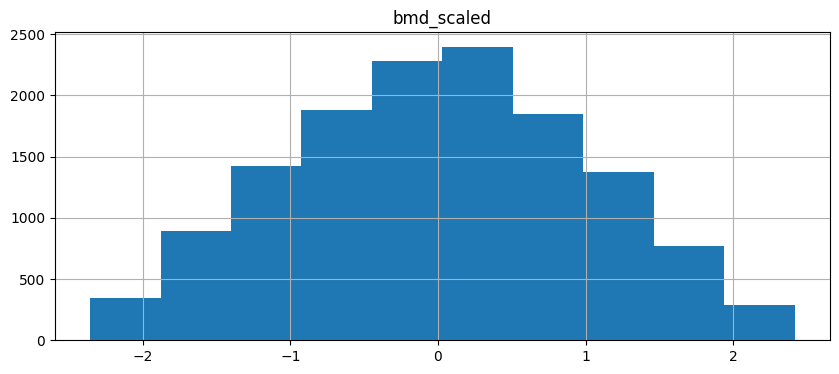

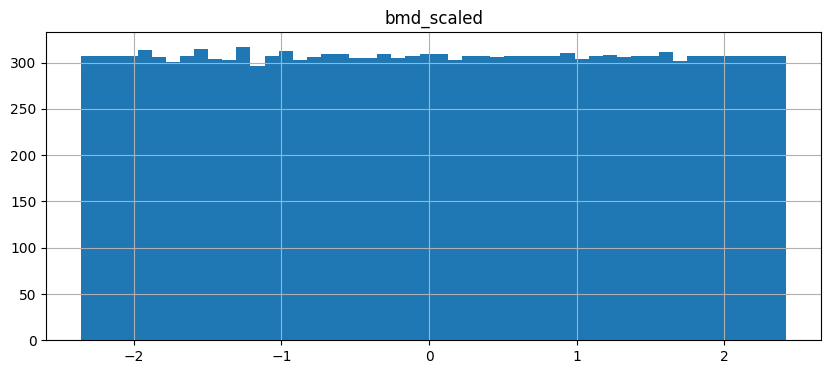

In [3]:
home_path = "/projects/ghnguyen_proj/project/git/ebmd/"
dataset_address = home_path + "data/vertebra/"
df = pd.read_csv(home_path + "instruction/lsbmd_phase1_instruction.csv")
df["image"] = dataset_address + df["FNAME"]
df["bmd_scaled"] = (df["BMD"] - df["mBMD"]) / df["sdBMD"] 
df["purpose"] = df["PURPOSE"]
df['exist'] = df['image'].map(os.path.exists)
df['bmd_category'] = pd.cut(df['bmd_scaled'], 50, labels=range(50)).astype("int")
df[['bmd_scaled']].hist(figsize = (10, 4))
print('images found of', df.shape[0], 'total')
raw_train_df = df[df['purpose'].isin(["TRAIN"])]
valid_df =  df[df['purpose'].isin(["VALID"])]
print('Train amount: ', raw_train_df.shape[0], 'Validation amount: ', valid_df.shape[0])
train_df = raw_train_df.groupby(['bmd_category']).apply(lambda x: x.sample(max(raw_train_df["bmd_category"].value_counts()), replace = True)).reset_index(drop = True)
train_df[['bmd_scaled']].hist(figsize = (10, 4), bins=50)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

In [4]:
BATCH_SIZE = 32

train_indices = list(train_df.index)
train_sampler = SubsetRandomSampler(train_indices)
train_transform = transforms.Compose(
    [transforms.ToTensor()
    ,transforms.RandomVerticalFlip()
    ,transforms.RandomAffine(degrees=(0, 5), translate=(0, 0.1), scale=(0.8, 1.2))
    ,transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
train_dataset = XBMD_Dataset(train_df, dataset_address, train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

valid_indices = list(valid_df.index)
valid_sampler = SubsetRandomSampler(valid_indices)
valid_transform = transforms.Compose(
    [transforms.ToTensor()                                
    ,transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
valid_dataset = XBMD_Dataset(valid_df, dataset_address, valid_transform)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)

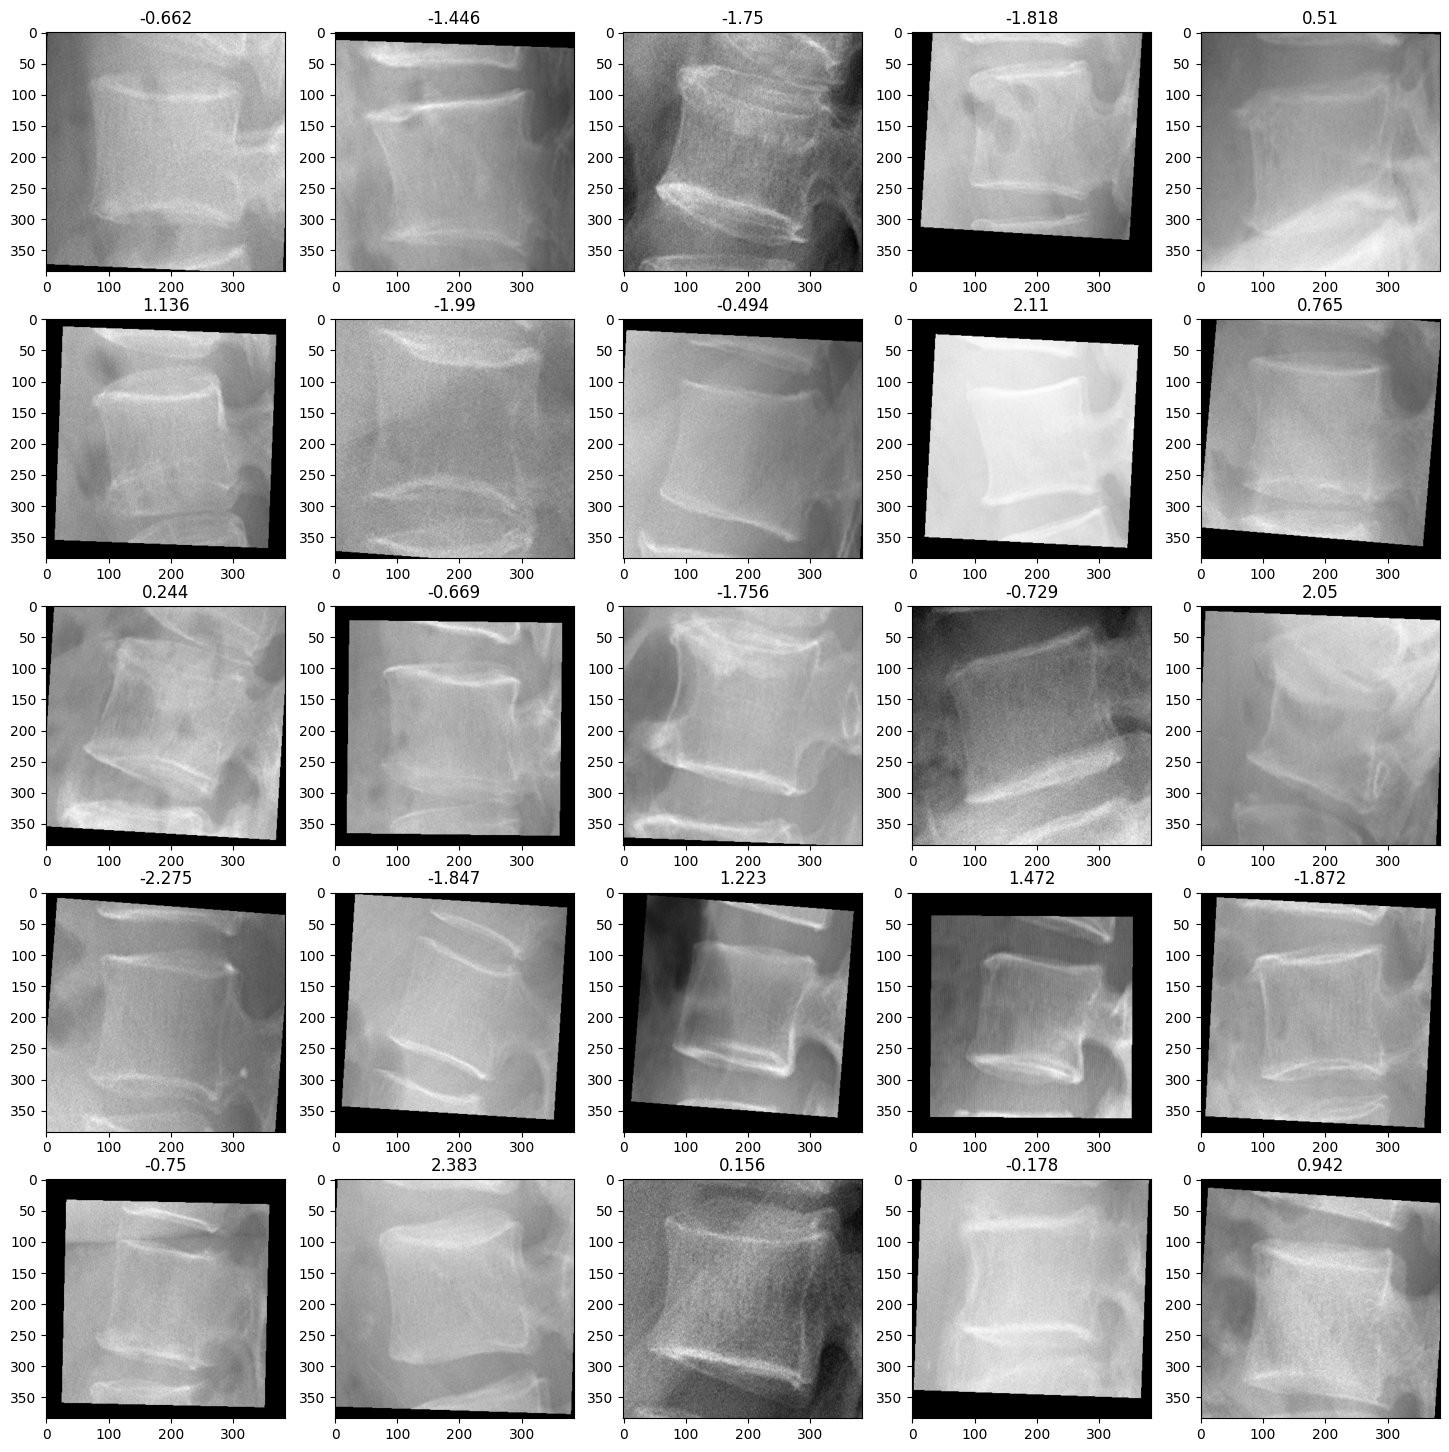

In [5]:
dataiter = iter(train_loader)
_, images, values = next(dataiter)
fig, axis = plt.subplots(5, 5, figsize=(18, 18))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, value = images[i], values[i]
        ax.imshow(img_display(image)@ [0.299, 0.587, 0.113], cmap = "gray")
        ax.set(title = f"{round(value.item(),3)}")

In [6]:
device = torch.device("cuda:0")
model = Network()
model.to(device)
print("Model initialised")

Model initialised


In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [8]:
model_path = 'model/lsbmd/VGG19/VGG19'

In [9]:
def descale(value, MEAN, SD):
    return value * SD + MEAN

n_epochs = 30
print_every = 1
description = "e01-30"

try:
    old_file_existed = True
    record_current = pd.read_csv(home_path + model_path + ".csv")
    record_new = []
    train_loss = record_current["train_loss"].to_list()
    val_loss = record_current["val_loss"].to_list()
    valid_loss_min = np.min(val_loss)
    learning_rate = record_current["lr"].values[-1]
    print("Old file existed.")
    print("learning rate: ", learning_rate)
except:
    old_file_existed = False
    record_current = []
    record_new = []
    train_loss = []
    val_loss = []
    valid_loss_min = np.inf
    learning_rate = 0.001
    print("Old file not existed, create new file...")
    print("learning rate: ", learning_rate)

total_step = len(train_loader)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total=0
    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f'Epoch [{epoch}/{n_epochs}]') #print epoch
        for batch_idx, (_, data_, target_) in enumerate(tepoch):
            data_, target_ = data_.to(device), target_.to(device)# on GPU
            optimizer.zero_grad()
            outputs = model(data_)
            loss = criterion(outputs, target_.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()    
        batch_loss = 0
        total_t=0
        correct_t=0
        with torch.no_grad():
            model.eval()
            for _, data_t, target_t in (valid_loader):
                data_t, target_t = data_t.to(device), target_t.to(device)
                outputs_t = model(data_t)
                loss_t = criterion(outputs_t, target_t.unsqueeze(1))
                batch_loss += loss_t.item()
            val_loss = np.append(val_loss, batch_loss/len(valid_loader))
            network_learned = batch_loss/len(valid_loader) < valid_loss_min
            if network_learned: 
                valid_loss_min = batch_loss/len(valid_loader)
                torch.save(model.state_dict(), home_path + model_path + "_" + description + '.pt')
                print('Detected network improvement, saving current model')
        scheduler.step(np.mean(val_loss))
        record_new.append([running_loss/total_step, batch_loss/len(valid_loader), optimizer.param_groups[0]['lr'], description])
    print('Train loss: {:.4f}, Valid loss: {:.4f}, Learn rate: {:.4f}\n' 
       .format(running_loss/total_step, batch_loss/len(valid_loader), optimizer.param_groups[0]['lr']))

model_test = Network()
model_test.load_state_dict(torch.load(home_path + model_path + "_" + description + '.pt'))
model_test.to("cpu")

test_df =  df[df['purpose'].isin(["TEST"])]
test_indices = list(test_df.index)
test_sampler = SubsetRandomSampler(test_indices)
test_transform = transforms.Compose(
    [transforms.ToTensor()                             
    ,transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
test_dataset = XBMD_Dataset(test_df, dataset_address, test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_indices), sampler=test_sampler)
dataiter = iter(test_loader)
images_address, images, values = next(dataiter)    
Y_true = []
Y_pred = []
with torch.no_grad():     
    model_test.eval()
    for image_address, image, value in (zip(images_address, images, values)):
        output_ = model_test(image.unsqueeze_(0))
        Y_pred.append(descale(output_.item(), df["mBMD"][0], df["sdBMD"][0]))
        Y_true.append(descale(value.item(), df["mBMD"][0], df["sdBMD"][0]))

if old_file_existed == True:
    record_new = pd.DataFrame(record_new, columns = ["train_loss","val_loss","lr","note"])
    record_new["epoch"] = range((np.max(record_current["epoch"])+1),(np.max(record_current["epoch"])+1+n_epochs),1)
    pd.concat([record_current, record_new], axis=0).reset_index(drop=True).to_csv(home_path + model_path + '.csv', index = False)   
    results_current = pd.read_csv(home_path + model_path + "_TESTRESULTS.csv")
    results_new = pd.DataFrame({"X": images_address,"Y_true": Y_true, "Y_pred": Y_pred, "note": description})
    pd.concat([results_current, results_new], axis=0).reset_index(drop=True).to_csv(home_path + model_path + '_TESTRESULTS.csv', index = False)
else:
    record_new = pd.DataFrame(record_new, columns = ["train_loss","val_loss","lr","note"])
    record_new["epoch"] = range(1,n_epochs+1,1)
    record_new.reset_index(drop=True).to_csv(home_path + model_path + '.csv', index =False)   
    results_new = pd.DataFrame({"X": images_address,"Y_true": Y_true, "Y_pred": Y_pred, "note": description})
    results_new.reset_index(drop=True).to_csv(home_path + model_path + '_TESTRESULTS.csv', index =False)
print("Round completed")

Old file not existed, create new file...
learning rate:  0.001


  0%|          | 0/480 [00:00<?, ?batch/s]

Detected network improvement, saving current model
Train loss: 1.3238, Valid loss: 0.8917, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Detected network improvement, saving current model
Train loss: 0.9084, Valid loss: 0.5656, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.7653, Valid loss: 0.5907, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Detected network improvement, saving current model
Train loss: 0.6759, Valid loss: 0.5063, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.6281, Valid loss: 0.5902, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Detected network improvement, saving current model
Train loss: 0.5812, Valid loss: 0.4605, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.5232, Valid loss: 0.4959, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.5053, Valid loss: 0.5119, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.4719, Valid loss: 0.5100, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.4523, Valid loss: 0.6944, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.4407, Valid loss: 0.4904, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.4235, Valid loss: 0.4896, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.3945, Valid loss: 0.7610, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.3864, Valid loss: 0.4775, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.3680, Valid loss: 0.5866, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.3498, Valid loss: 0.4855, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.3491, Valid loss: 0.5023, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Detected network improvement, saving current model
Train loss: 0.3359, Valid loss: 0.4420, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.3208, Valid loss: 0.4477, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.3141, Valid loss: 0.5013, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.2981, Valid loss: 0.4938, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.2946, Valid loss: 0.4589, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.2909, Valid loss: 0.5194, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.2773, Valid loss: 0.4594, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.2717, Valid loss: 0.5737, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.2603, Valid loss: 0.4899, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.2533, Valid loss: 0.5006, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.2459, Valid loss: 0.5065, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.2417, Valid loss: 0.4995, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.2358, Valid loss: 0.4643, Learn rate: 0.0010

Round completed


In [11]:
def descale(value, MEAN, SD):
    return value * SD + MEAN

n_epochs = 30
print_every = 1
description = "e61-90"

try:
    old_file_existed = True
    record_current = pd.read_csv(home_path + model_path + ".csv")
    record_new = []
    train_loss = record_current["train_loss"].to_list()
    val_loss = record_current["val_loss"].to_list()
    valid_loss_min = np.min(val_loss)
    learning_rate = record_current["lr"].values[-1]
    print("Old file existed.")
except:
    old_file_existed = False
    record_current = []
    record_new = []
    train_loss = []
    val_loss = []
    valid_loss_min = np.inf
    learning_rate = 0.001
    print("Old file not existed, create new file...")

print("learning rate: ", learning_rate)
    
total_step = len(train_loader)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total=0
    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f'Epoch [{epoch}/{n_epochs}]') #print epoch
        for batch_idx, (_, data_, target_) in enumerate(tepoch):
            data_, target_ = data_.to(device), target_.to(device)# on GPU
            optimizer.zero_grad()
            outputs = model(data_)
            loss = criterion(outputs, target_.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()    
        batch_loss = 0
        total_t=0
        correct_t=0
        with torch.no_grad():
            model.eval()
            for _, data_t, target_t in (valid_loader):
                data_t, target_t = data_t.to(device), target_t.to(device)
                outputs_t = model(data_t)
                loss_t = criterion(outputs_t, target_t.unsqueeze(1))
                batch_loss += loss_t.item()
            val_loss = np.append(val_loss, batch_loss/len(valid_loader))
            network_learned = batch_loss/len(valid_loader) < valid_loss_min
            if network_learned: 
                valid_loss_min = batch_loss/len(valid_loader)
                torch.save(model.state_dict(), home_path + model_path + "_" + description + '.pt')
                print('Detected network improvement, saving current model')
        scheduler.step(np.mean(val_loss))
        record_new.append([running_loss/total_step, batch_loss/len(valid_loader), optimizer.param_groups[0]['lr'], description])
    print('Train loss: {:.4f}, Valid loss: {:.4f}, Learn rate: {:.4f}\n' 
       .format(running_loss/total_step, batch_loss/len(valid_loader), optimizer.param_groups[0]['lr']))

model_test = Network()
model_test.load_state_dict(torch.load(home_path + model_path + "_" + description + '.pt'))
model_test.to("cpu")

test_df =  df[df['purpose'].isin(["TEST"])]
test_indices = list(test_df.index)
test_sampler = SubsetRandomSampler(test_indices)
test_transform = transforms.Compose(
    [transforms.ToTensor()                             
    ,transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
test_dataset = XBMD_Dataset(test_df, dataset_address, test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_indices), sampler=test_sampler)
dataiter = iter(test_loader)
images_address, images, values = next(dataiter)    
Y_true = []
Y_pred = []

with torch.no_grad():     
    model_test.eval()
    for image_address, image, value in (zip(images_address, images, values)):
        output_ = model_test(image.unsqueeze_(0))
        Y_pred.append(descale(output_.item(), df["mBMD"][0], df["sdBMD"][0]))
        Y_true.append(descale(value.item(), df["mBMD"][0], df["sdBMD"][0]))

if old_file_existed == True:
    record_new = pd.DataFrame(record_new, columns = ["train_loss","val_loss","lr","note"])
    record_new["epoch"] = range((np.max(record_current["epoch"])+1),(np.max(record_current["epoch"])+1+n_epochs),1)
    pd.concat([record_current, record_new], axis=0).reset_index(drop=True).to_csv(home_path + model_path + '.csv', index = False)   
    results_current = pd.read_csv(home_path + model_path + "_TESTRESULTS.csv")
    results_new = pd.DataFrame({"X": images_address,"Y_true": Y_true, "Y_pred": Y_pred, "note": description})
    pd.concat([results_current, results_new], axis=0).reset_index(drop=True).to_csv(home_path + model_path + '_TESTRESULTS.csv', index = False)
else:
    record_new = pd.DataFrame(record_new, columns = ["train_loss","val_loss","lr","note"])
    record_new["epoch"] = range(1,n_epochs+1,1)
    record_new.reset_index(drop=True).to_csv(home_path + model_path + '.csv', index =False)   
    results_new = pd.DataFrame({"X": images_address,"Y_true": Y_true, "Y_pred": Y_pred, "note": description})
    results_new.reset_index(drop=True).to_csv(home_path + model_path + '_TESTRESULTS.csv', index =False)
print("Round completed")

Old file existed.
learning rate:  0.001


  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1275, Valid loss: 0.4505, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1280, Valid loss: 0.5068, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1239, Valid loss: 0.4570, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1220, Valid loss: 0.4771, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1194, Valid loss: 0.5445, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1185, Valid loss: 0.4939, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1171, Valid loss: 0.4560, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1173, Valid loss: 0.4594, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1115, Valid loss: 0.4581, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1143, Valid loss: 0.4850, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1101, Valid loss: 0.4781, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1100, Valid loss: 0.5071, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1083, Valid loss: 0.4525, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1065, Valid loss: 0.4513, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1051, Valid loss: 0.5135, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1044, Valid loss: 0.4464, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1054, Valid loss: 0.4903, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1057, Valid loss: 0.4911, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.0981, Valid loss: 0.4555, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.1002, Valid loss: 0.4495, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.0982, Valid loss: 0.4513, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.0954, Valid loss: 0.4443, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.0959, Valid loss: 0.4586, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.0977, Valid loss: 0.4561, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.0917, Valid loss: 0.4538, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.0953, Valid loss: 0.4587, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.0911, Valid loss: 0.4462, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.0875, Valid loss: 0.4935, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.0882, Valid loss: 0.4638, Learn rate: 0.0010



  0%|          | 0/480 [00:00<?, ?batch/s]

Train loss: 0.0880, Valid loss: 0.4565, Learn rate: 0.0010



FileNotFoundError: [Errno 2] No such file or directory: '/projects/ghnguyen_proj/project/git/ebmd/model/lsbmd/VGG19/VGG19_e61-90.pt'

In [7]:
def descale(value, MEAN, SD):
    return value * SD + MEAN

device = torch.device("cuda:1")
model_path = 'model/lsbmd/VGG19/VGG19'
model_test = Network()
model_test.load_state_dict(torch.load("../model/lsbmd/VGG19/VGG19_e31-60.pt"))
model_test.to(device)
description = "e31-60"

test_df =  df[df['purpose'].isin(["VALID"])]
test_indices = list(test_df.index)
test_sampler = SubsetRandomSampler(test_indices)
test_transform = transforms.Compose(
    [transforms.ToTensor()                             
    ,transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
test_dataset = XBMD_Dataset(test_df, dataset_address, test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_indices), sampler=test_sampler)
dataiter = iter(test_loader)
images_address, images, values = next(dataiter)    
Y_true = []
Y_pred = []

with torch.no_grad():     
    model_test.eval()
    for image_address, image, value in (zip(images_address, images, values)):
        print(image_address)
        image, value = image.to(device), value.to(device)
        output = model_test(image.unsqueeze_(0))
        Y_pred.append(descale(output.item(), df["mBMD"][0], df["sdBMD"][0]))
        Y_true.append(descale(value.item(), df["mBMD"][0], df["sdBMD"][0]))  

results_new = pd.DataFrame({"X": images_address,"Y_true": Y_true, "Y_pred": Y_pred, "note": description})
results_new.reset_index(drop=True).to_csv(home_path + model_path + '_VALIDRESULTS.csv', index =False)
print("Round completed")

/projects/ghnguyen_proj/project/git/ebmd/data/vertebra/1207_1_L4.jpg
/projects/ghnguyen_proj/project/git/ebmd/data/vertebra/3459_1_L2.jpg
/projects/ghnguyen_proj/project/git/ebmd/data/vertebra/4058_1_L4.jpg
/projects/ghnguyen_proj/project/git/ebmd/data/vertebra/699_1_L2.jpg
/projects/ghnguyen_proj/project/git/ebmd/data/vertebra/3411_1_L1.jpg
/projects/ghnguyen_proj/project/git/ebmd/data/vertebra/2223_1_L2.jpg
/projects/ghnguyen_proj/project/git/ebmd/data/vertebra/3447_1_L1.jpg
/projects/ghnguyen_proj/project/git/ebmd/data/vertebra/3464_1_L3.jpg
/projects/ghnguyen_proj/project/git/ebmd/data/vertebra/2587_1_L4.jpg
/projects/ghnguyen_proj/project/git/ebmd/data/vertebra/2492_1_L2.jpg
/projects/ghnguyen_proj/project/git/ebmd/data/vertebra/1574_1_L1.jpg
/projects/ghnguyen_proj/project/git/ebmd/data/vertebra/3346_1_L2.jpg
/projects/ghnguyen_proj/project/git/ebmd/data/vertebra/658_1_L1.jpg
/projects/ghnguyen_proj/project/git/ebmd/data/vertebra/3857_1_L2.jpg
/projects/ghnguyen_proj/project/git/

Round completed


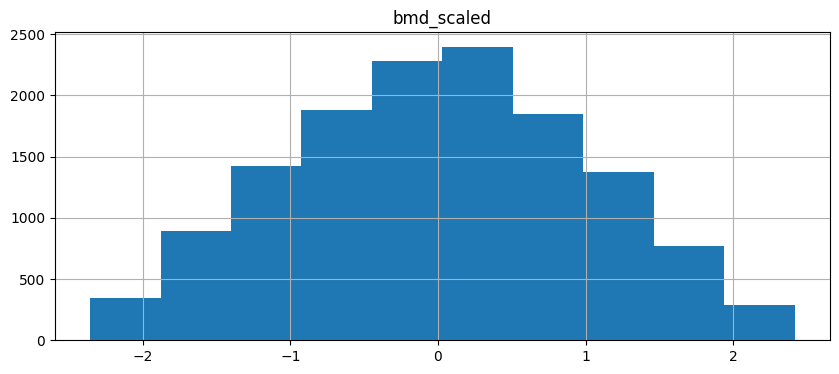

In [12]:
home_path = "/projects/ghnguyen_proj/project/git/ebmd/"
dataset_address = home_path + "data/vertebra/"
df = pd.read_csv(home_path + "instruction/lsbmd_phase1_instruction.csv")
df["image"] = dataset_address + df["FNAME"]
df["bmd_scaled"] = (df["BMD"] - df["mBMD"]) / df["sdBMD"]
df["purpose"] = df["PURPOSE"]
df['exist'] = df['image'].map(os.path.exists)
df['bmd_category'] = pd.cut(df['bmd_scaled'], 50, labels=range(50)).astype("int")
df[['bmd_scaled']].hist(figsize = (10, 4))

device = torch.device("cuda:1")
model_path = 'model/lsbmd/VGG19/VGG19_ENSEMBLE'
model_test = Network()
model_test.load_state_dict(torch.load("../model/lsbmd/VGG19/VGG19_e31-60.pt"))
model_test.to(device)

test_df =  df[df['purpose'].isin(["TEST"])]
test_indices = list(test_df.index)
test_sampler = SubsetRandomSampler(test_indices)
test_transform = transforms.Compose(
    [transforms.ToTensor()                             
    ,transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
test_dataset = XBMD_Dataset(test_df, dataset_address, test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_indices), sampler=test_sampler)
dataiter = iter(test_loader)
images_address, images, values = next(dataiter)    
Y_true, Y_pred = [], []
with torch.no_grad():     
    model_test.eval()
    for image_address, image, value in (zip(images_address, images, values)):
        image, value = image.to(device), value.to(device)
        output_ = model_test(image.unsqueeze_(0))
        Y_pred.append(descale(output_.item(), df["mBMD"][0], df["sdBMD"][0]))
        Y_true.append(descale(value.item(), df["mBMD"][0], df["sdBMD"][0]))

results_new = pd.DataFrame({"X": images_address,"Y_true": Y_true, "Y_pred": Y_pred})
results_new["X"] = results_new["X"].apply(os.path.basename)
results_new.reset_index(drop=True).to_csv(home_path + model_path + '_TEST.csv', index =False)

test_df =  df[df['purpose'].isin(["VALID"])]
test_indices = list(test_df.index)
test_sampler = SubsetRandomSampler(test_indices)
test_transform = transforms.Compose(
    [transforms.ToTensor()                             
    ,transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
test_dataset = XBMD_Dataset(test_df, dataset_address, test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_indices), sampler=test_sampler)
dataiter = iter(test_loader)
images_address, images, values = next(dataiter)    
Y_true, Y_pred = [], []
with torch.no_grad():     
    model_test.eval()
    for image_address, image, value in (zip(images_address, images, values)):
        image, value = image.to(device), value.to(device)
        output_ = model_test(image.unsqueeze_(0))
        Y_pred.append(descale(output_.item(), df["mBMD"][0], df["sdBMD"][0]))
        Y_true.append(descale(value.item(), df["mBMD"][0], df["sdBMD"][0]))

results_new = pd.DataFrame({"X": images_address,"Y_true": Y_true, "Y_pred": Y_pred})
results_new["X"] = results_new["X"].apply(os.path.basename)
results_new.reset_index(drop=True).to_csv(home_path + model_path + '_TRAIN.csv', index =False)
print("Round completed")

In [ ]:
home_path = "/projects/ghnguyen_proj/project/git/ebmd/"
dataset_address = home_path + "data/hip_total/"
df = pd.read_csv(home_path + "instruction/lsbmd_phase1_instruction.csv")
df["image"] = dataset_address + df["FNAME"]
df["bmd_scaled"] = (df["BMD"] - df["mBMD"]) / df["sdBMD"]
df["purpose"] = df["PURPOSE"]
df['exist'] = df['image'].map(os.path.exists)
df['bmd_category'] = pd.cut(df['bmd_scaled'], 50, labels=range(50)).astype("int")
df[['bmd_scaled']].hist(figsize = (10, 4))

device = torch.device("cuda:1")
model_path = 'model/lsbmd/VGG19/VGG19_ENSEMBLE'
model_test = Network()
model_test.load_state_dict(torch.load("../model/lsbmd/VGG19/VGG19_e31-60.pt"))
model_test.to(device)

test_df =  df[df['purpose'].isin(["TEST"])]
test_indices = list(test_df.index)
test_sampler = SubsetRandomSampler(test_indices)
test_transform = transforms.Compose(
    [transforms.ToTensor()                             
    ,transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
test_dataset = XBMD_Dataset(test_df, dataset_address, test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_indices), sampler=test_sampler)
dataiter = iter(test_loader)
images_address, images, values = next(dataiter)    
Y_true, Y_pred = [], []
with torch.no_grad():     
    model_test.eval()
    for image_address, image, value in (zip(images_address, images, values)):
        image, value = image.to(device), value.to(device)
        output_ = model_test(image.unsqueeze_(0))
        Y_pred.append(descale(output_.item(), df["mBMD"][0], df["sdBMD"][0]))
        Y_true.append(descale(value.item(), df["mBMD"][0], df["sdBMD"][0]))

results_new = pd.DataFrame({"X": images_address,"Y_true": Y_true, "Y_pred": Y_pred})
results_new["X"] = results_new["X"].apply(os.path.basename)
results_new.reset_index(drop=True).to_csv(home_path + model_path + '_TEST.csv', index =False)

test_df =  df[df['purpose'].isin(["VALID"])]
test_indices = list(test_df.index)
test_sampler = SubsetRandomSampler(test_indices)
test_transform = transforms.Compose(
    [transforms.ToTensor()                             
    ,transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
test_dataset = XBMD_Dataset(test_df, dataset_address, test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_indices), sampler=test_sampler)
dataiter = iter(test_loader)
images_address, images, values = next(dataiter)    
Y_true, Y_pred = [], []
with torch.no_grad():     
    model_test.eval()
    for image_address, image, value in (zip(images_address, images, values)):
        image, value = image.to(device), value.to(device)
        output_ = model_test(image.unsqueeze_(0))
        Y_pred.append(descale(output_.item(), df["mBMD"][0], df["sdBMD"][0]))
        Y_true.append(descale(value.item(), df["mBMD"][0], df["sdBMD"][0]))

results_new = pd.DataFrame({"X": images_address,"Y_true": Y_true, "Y_pred": Y_pred})
results_new["X"] = results_new["X"].apply(os.path.basename)
results_new.reset_index(drop=True).to_csv(home_path + model_path + '_TRAIN.csv', index =False)
print("Round completed")